In [19]:
# 라이브러리
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [20]:
# device setting
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

print(device)

cpu


In [21]:
# directory setting
class ROOTDIR:
    x_train = '/home/kmk/DL_final_project/leftImg8bit/train/'
    x_val = '/home/kmk/DL_final_project/leftImg8bit/val/'
    y_train = '/home/kmk/DL_final_project/gtFine/train/'
    y_val = '/home/kmk/DL_final_project/gtFine/val/'

In [22]:
# image file list
x_train_filenames = sorted(glob.glob(ROOTDIR.x_train+"*.png"))
x_val_filenames = sorted(glob.glob(ROOTDIR.x_val+"*.png"))

y_train_filenames = sorted(glob.glob(ROOTDIR.y_train+"*_gtFine_color.png"))
y_val_filenames = sorted(glob.glob(ROOTDIR.y_val+"*_gtFine_color.png"))

len(x_train_filenames), len(x_val_filenames), len(y_train_filenames), len(y_val_filenames)

(2975, 500, 2975, 500)

In [23]:
# Dataset
class Cityscape(Dataset):
    def __init__(self, img_list, label_list, transform=None):
        self.img_list = img_list
        self.label_list = label_list
        self.transform = transform
        
    # img list 길이
    def __len__(self):
        return len(self.img_list)
    
    # get image, label
    def __getitem__(self, idx):
        img = plt.imread(os.path.join(ROOTDIR.x_train, self.img_list[idx]))
        label = plt.imread(os.path.join(ROOTDIR.y_train, self.label_list[idx]))
        
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)
            
        return img, label           

In [24]:
# Define Transforms
train_Transforms = transforms.Compose([
    transforms.ToTensor(),
])
val_Transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [25]:
# Data Augmentation
train_dataset = Cityscape(x_train_filenames, y_train_filenames, train_Transforms)
val_dataset = Cityscape(x_val_filenames, y_val_filenames, val_Transforms)

In [26]:
# Batch
batch_size = 10

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, 1, shuffle=True)

In [27]:
# visualize batch
def show_batch(batch, size):
    img, label = batch[0], batch[1]
    img = img.numpy()
    label = label.numpy()
    
    fig, ax = plt.subplots(size, 2, figsize=(10, 20))
    
    for i in range(size):
        ax[i][0].imshow(np.transpose(img[i], (1, 2, 0)))
        ax[i][1].imshow(np.transpose(label[i], (1,2,0)))

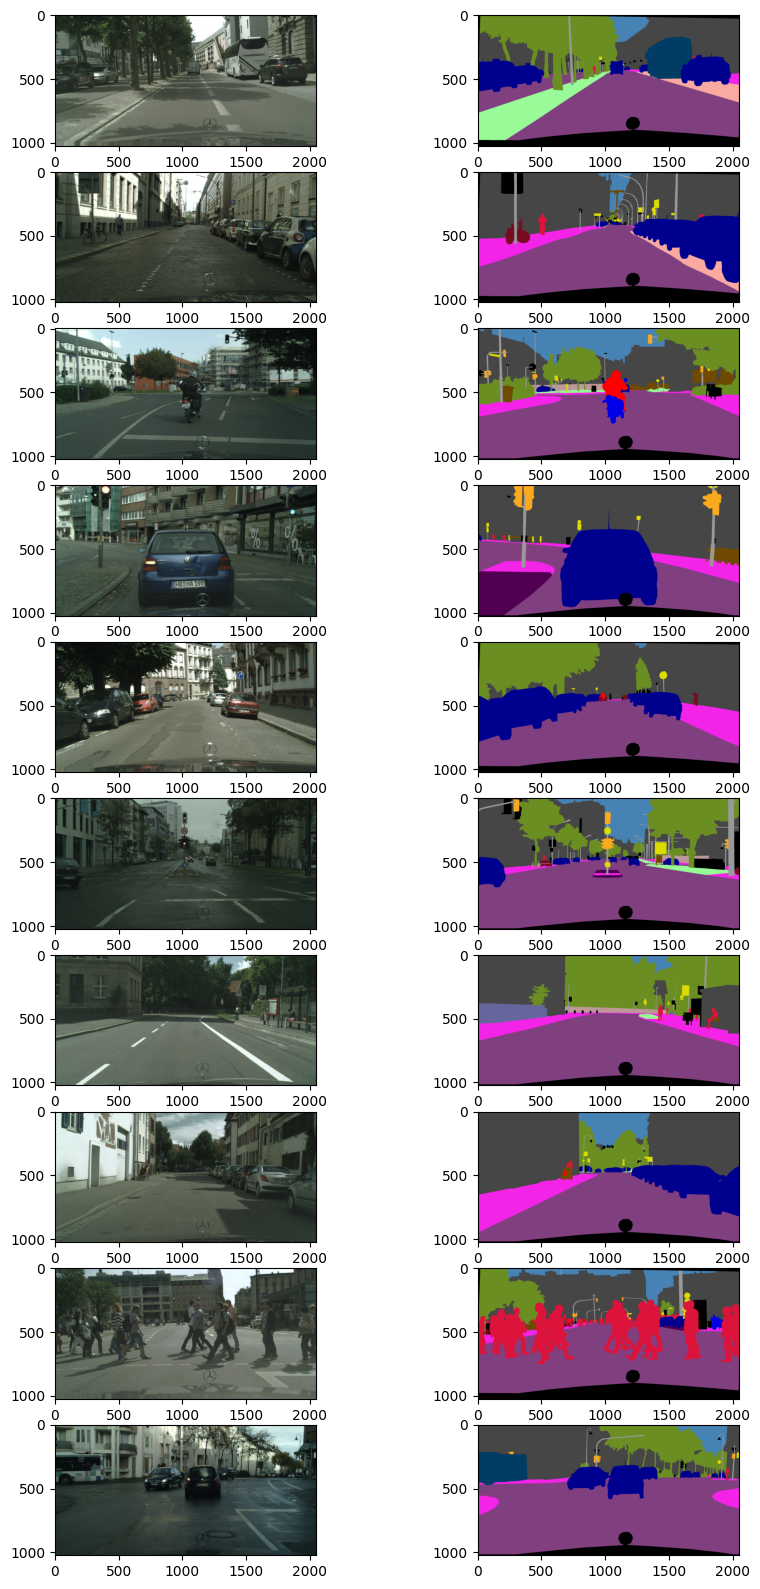

In [28]:
data_iter = iter(train_loader)
show_batch(next(data_iter), batch_size)

In [ ]:
# visualize
def show(lst, loop=1):
    for i in range(loop):
        if len(lst[0].shape) > 3:
            